출처 : https://www.kaggle.com/code/ash316/eda-to-prediction-dietanic/notebook

## Contents

Part1: Exploratory Data Analysis(EDA):  
1)Analysis of the features.
</br></br>
2)Finding any relations or trends considering multiple features.
</br></br>
Part2: Feature Engineering and Data Cleaning:    
1)Adding any few features.
</br></br>
2)Removing redundant features.
</br></br>
3)Converting features into suitable form for modeling.
</br></br>
Part3: Predictive Modeling  
1)Running Basic Algorithms.
</br></br>
2)Cross Validation.
</br></br>
3)Ensembling.
</br></br>
4)Important Features Extraction.

### Part1: Exploratory Data Analysis(EDA)

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
train_path = 'data/train.csv'
test_path = 'data/test.csv'
submission_path = 'data/gender_submission.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
submission = pd.read_csv(submission_path)

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 결측치 확인
train.isnull().sum()  # checking for total null values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- age, cabin, embarked 결측치 존재
- 이후에 수정 필요

__생존자 확인__
1. train 생존자 pie그래프 

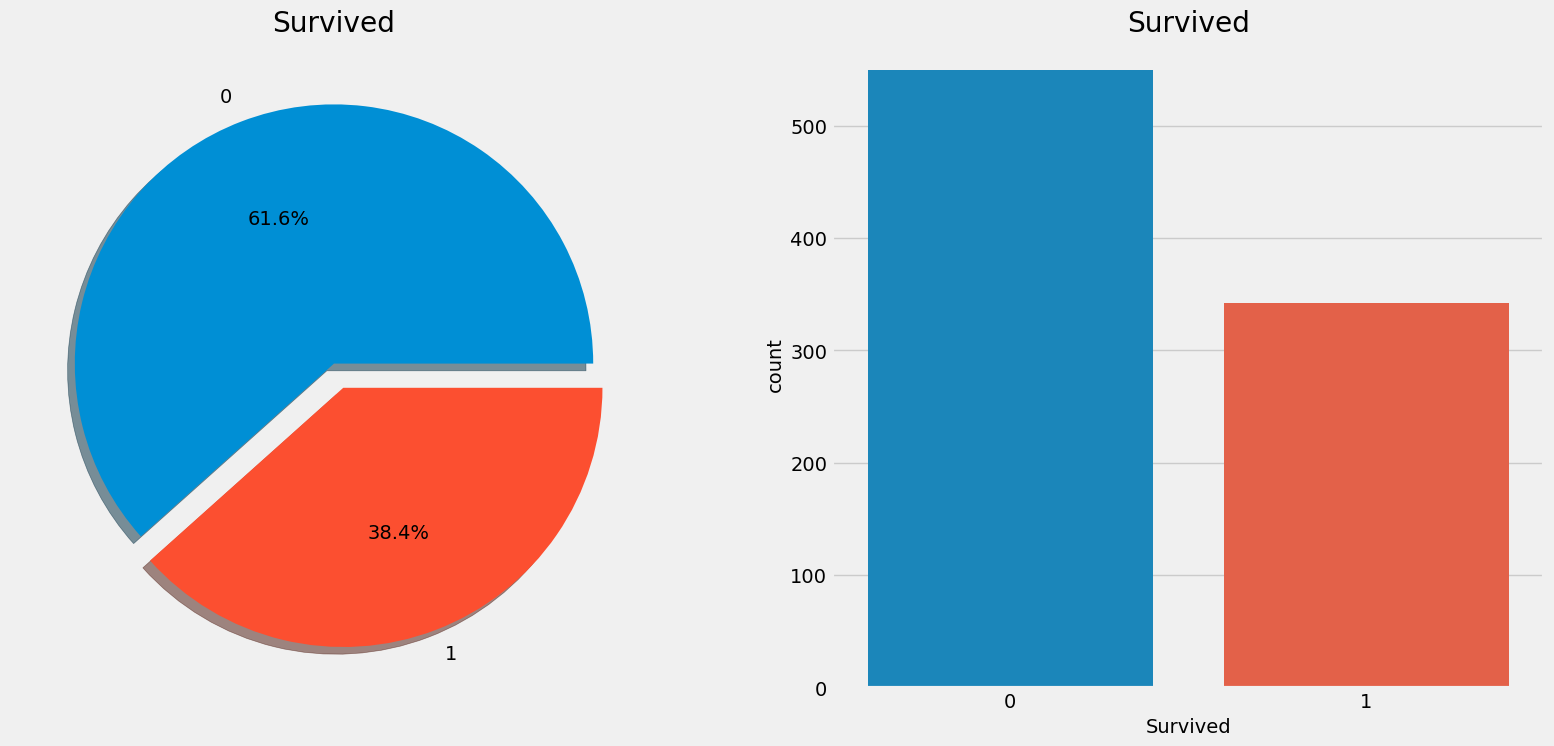

In [5]:
f, ax = plt.subplots(1,2,figsize=(18,8))
train['Survived'].value_counts().plot.pie(explode=[0,0.1], # 원의 틈이 얼마나 벌어져있는지
                                          autopct='%1.1f%%',
                                          ax=ax[0],
                                          shadow=True)  # 그림자 존재재
ax[0].set_title('Survived')
ax[0].set_ylabel('')
sns.countplot(x='Survived', data=train, ax=ax[1])
ax[1].set_title('Survived')
plt.show()

이 증거는 많은 승객이 생존하지 못했음을 보여준다. 

891명의 승객 중, 약 350 명 정도만 생존

다른 피쳐들을 사용해서 생존률을 검토해봐야 한다. 

### Types Of Features 
1. Categorical Features : 
    - 범주형 피쳐
2. Ordinal Features :
    - 범주형 데이터의 일종
    - 크고 작음의 구분이 있는 경우 ordinal features라고 함
3. Continous Feature:
    - 연속형 피쳐쳐

### Analysing The Features

### Sex -> Categorical Feature

In [6]:
train.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

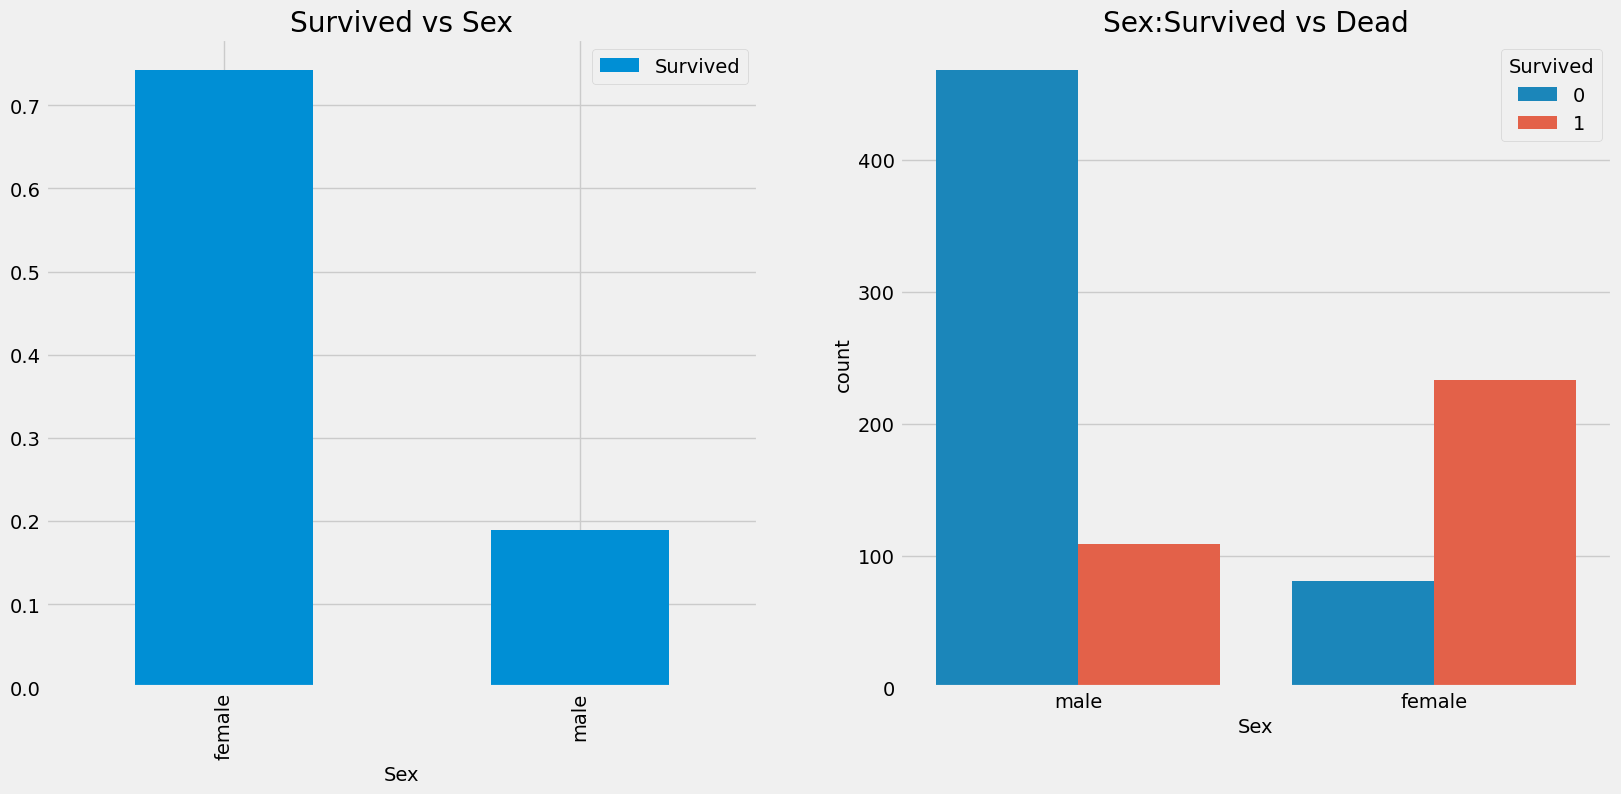

In [7]:
f, ax = plt.subplots(1,2,figsize = (18,8))
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(data=train,x='Sex', hue='Survived', ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

This looks intersting. The number of men on the ship is lot more than the number of women. Still the number of women saved is almost twice number of males saved is twice the number of male saved. The survival rates for a women on the shop is around 75% while that for men in around 18-19%.

This looks to be a very important feature for modeling. But is it the best?? Lets check other features.

### Pclass -> Ordinal Feature 

ordinal feature = 순서 피쳐


In [8]:
'''
crosstab은 범주형 데이터를 교차로 비교할 수 있는 기능
margin = 전체값
normalize = 비율화
style.background_gradient = 빈도에 따른 색 표현
'''
pd.crosstab(train.Pclass, train.Survived, margins=True, normalize =True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,0.089787,0.152637,0.242424
2,0.108866,0.097643,0.206510
3,0.417508,0.133558,0.551066
All,0.616162,0.383838,1.000000


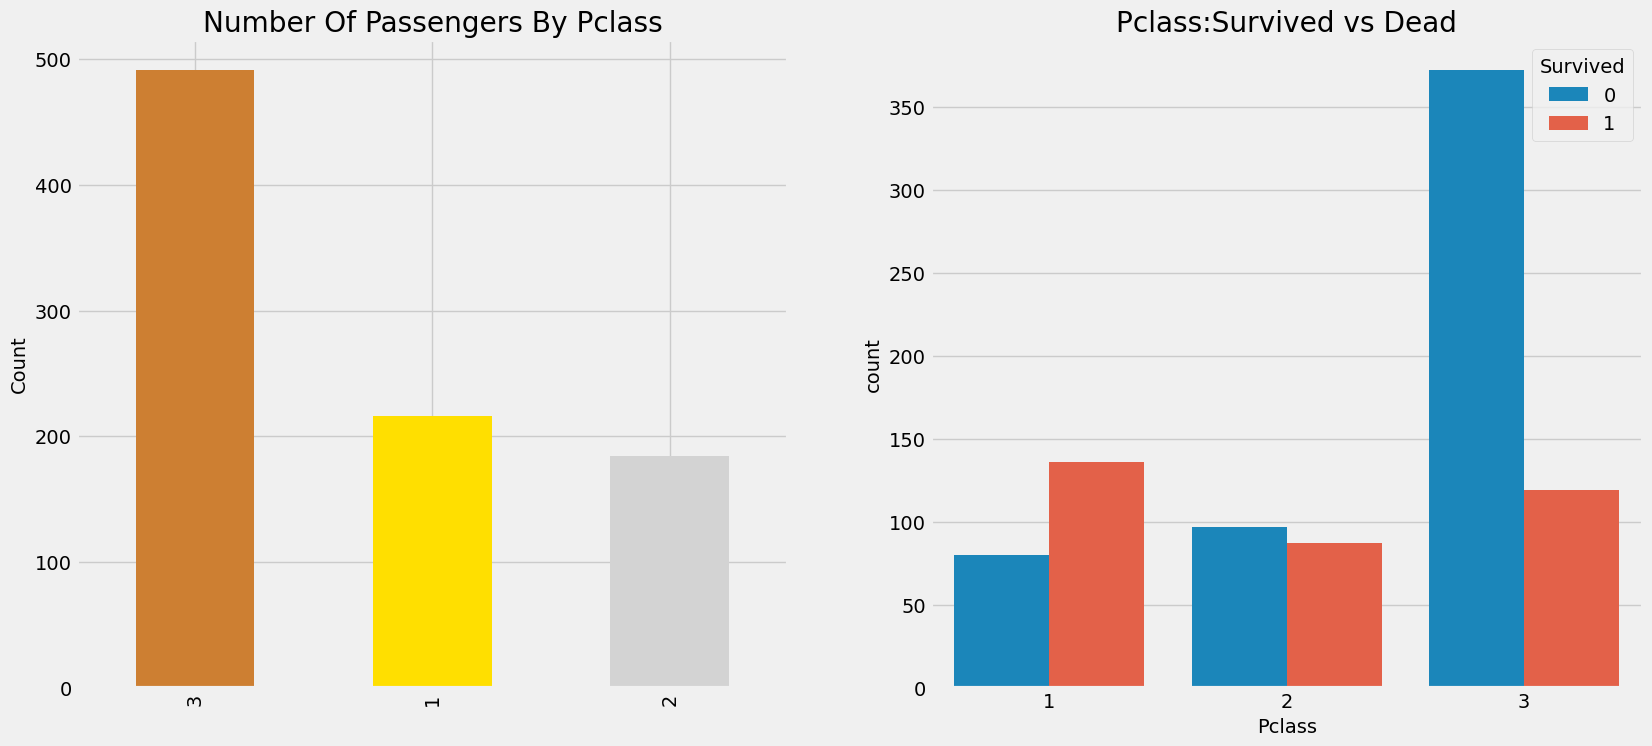

In [9]:
'''
(1,2)의 sublot을 만들고 
pclass에 따라서 죽은사람과 산 사람이 차이가 나는지 막대그래프를 통해 확인해라
'''
f, ax = plt.subplots(1,2, figsize = (18,8))
train['Pclass'].value_counts().plot.bar(color=['#CD7F32','#FFDF00','#D3D3D3'], ax=ax[0]) #pclass 각 등급별 사람 수 
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')
sns.countplot(data=train, x='Pclass', hue='Survived', ax=ax[1]) #pclass에 따른 생존률
ax[1].set_title('Pclass:Survived vs Dead')
plt.show()

people say __Money Can't Buy Eveerything.__ But we can clearly see that Passengers Of Pclass 1 were given a very high priority while rescue. Even though the number of Passengers in Pclass 3 were in Pclass 3 were a lot higher, still the number of survival from them is very low, somewhere around 25%. 

For Pclass 1% survived is around 63% while for Pclass2 is around 48%. So money and status matters. Such a materialistic world.

Lets Dive in little vit more and check for other intersting observations Lets check survival rate with __Sex and Pclass__ Together.

In [10]:
'''
성별과 생존자의 관계를 비교하는데 좌성등급을 추가해서 비교
성별을 생존자로 세부분할 해서 pclass와 비교
[안에 넣은 feature 순서대로 세분화]
'''
pd.crosstab([train.Sex, train.Survived], train.Pclass, margins=True).style.background_gradient(cmap='summer_r')

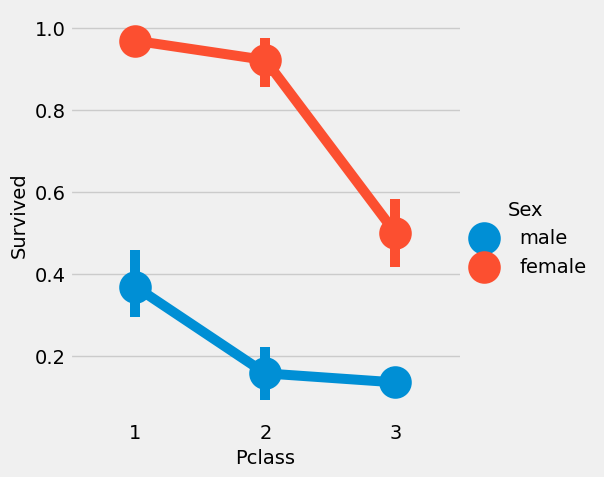

In [11]:
'''
기존의 factorplot이 삭제되면서 catplot의 kind를 주는 것으로 여러가지 변주가 가능해 졌다. 
'''
sns.catplot(x='Pclass', y='Survived', hue='Sex', kind='point' ,data=train)
plt.show()

Looking at the CrosTab and the Catplot, we can easily infer that survival for __Women from Pclass1__ is about 95-96%, as only 3 out of 94 Women from Pclass1 died.

It is evident that irrespective of Pclass, Women were given first priority while rescue. Even Men from Pclass1 have a very low survival rate.

Looks like Pclass is also an important feature. Lets analyse other features.

### Age -> Continous Feature

In [12]:
print('Oldest Passenger was of: ', train['Age'].max(), 'Years')
print('Youngest Passenger was of: ', train['Age'].min(), 'Years')
print('Average Age on the ship: ', train['Age'].mean(), 'Years')

Oldest Passenger was of:  80.0 Years
Youngest Passenger was of:  0.42 Years
Average Age on the ship:  29.69911764705882 Years


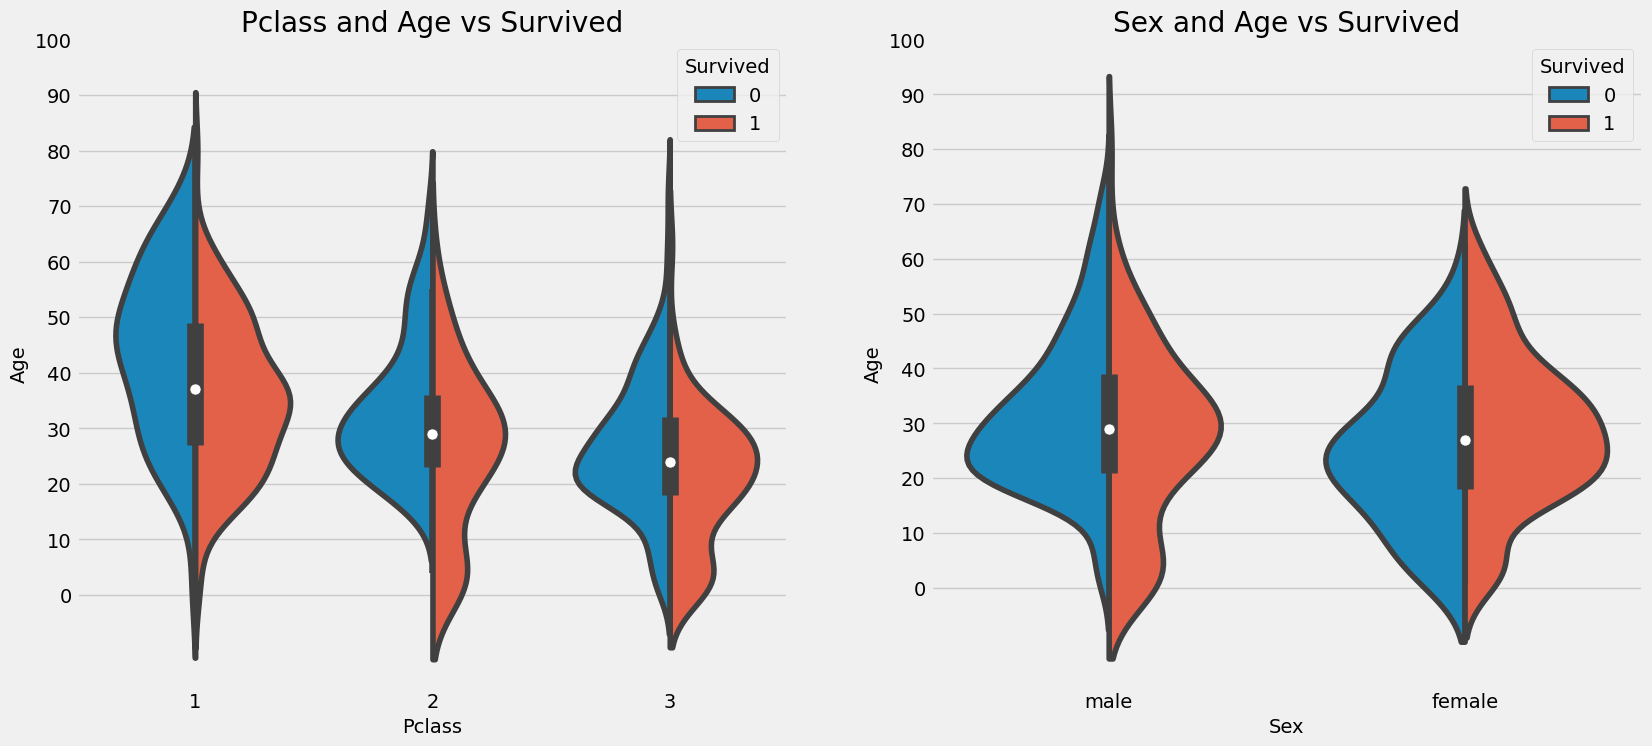

In [13]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot(data=train,x="Pclass", y='Age', hue='Survived', split=True,ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0,110,10))
sns.violinplot(data=train, x='Sex', y='Age', hue='Survived', split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0,110,10))
plt.show()

__Observations:__
1) The number of children increases with Pclass and the survivalrate for passeneegers below Age 10(i.e children) looks to be good irrespective of the Pclass. 

2) Survival chance for Passenegers aged 20-50 from Pclass1 is high and is even better from Women.

3) For males, the survival chances decreases with an increase in age. 


As we had seen earlierm the Age feature has 177 null values. To replace these NaN values, we can assign them the mean age of the dataset.

But the problem is, there were many people with many different ages. We just can't assign a 4 yer kid with the mean age that is 29 years. Is there any way to dind out what age-band does the passenger lie??

__Bingo!!__, we can check the Name feature. Looking upon the featurem we can see that the names have a salutation like Mr or Mrs. Thus we can assign the mean values of Mr and Mrs to the respective groups.

In [14]:
train['Initial']=0
for i in train:
    train['Initial']=train.Name.str.extract('([A-Za-z]+)\.') # lets extract the Salutations


Okay so here we are using the Regex: [A-Za-z]+).. So what it does ism it looks for strings which lie between __A-Z or a-z__ and followed by a __.(dot)__. So we successfully extract the Initials from the Name. 

In [15]:
pd.crosstab(train.Initial, train.Sex).T.style.background_gradient(cmap='summer_r') # Checking the Initials with the Sex

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


Okay so ther are some misspelled Initials Like Mlle of Mme that stand for Miss. I will replace them with Miss and same thing for other values.

In [16]:
train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
    ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [17]:
train.groupby('Initial')['Age'].mean()

Initial
Master     4.574167
Miss      21.860000
Mr        32.739609
Mrs       35.981818
Other     45.888889
Name: Age, dtype: float64

### Filling NaN Ages

In [18]:
## Assigning the NaN Values with the Ceil values of the mean ages
train.loc[(train.Age.isnull())&(train.Initial=='Mr'), 'Age'] == 33  # 나이가 null 값이면서 이니셜이 mr 인 사람들의 나이를 33으로 대체한다. 
train.loc[(train.Age.isnull())&(train.Initial=='Mrs'), 'Age'] == 36
train.loc[(train.Age.isnull())&(train.Initial=='Master'), 'Age'] == 5
train.loc[(train.Age.isnull())&(train.Initial=='Miss'), 'Age'] == 22
train.loc[(train.Age.isnull())&(train.Initial=='Other'), 'Age'] == 46

Series([], Name: Age, dtype: bool)

In [19]:
train.Age.isnull().any()

True

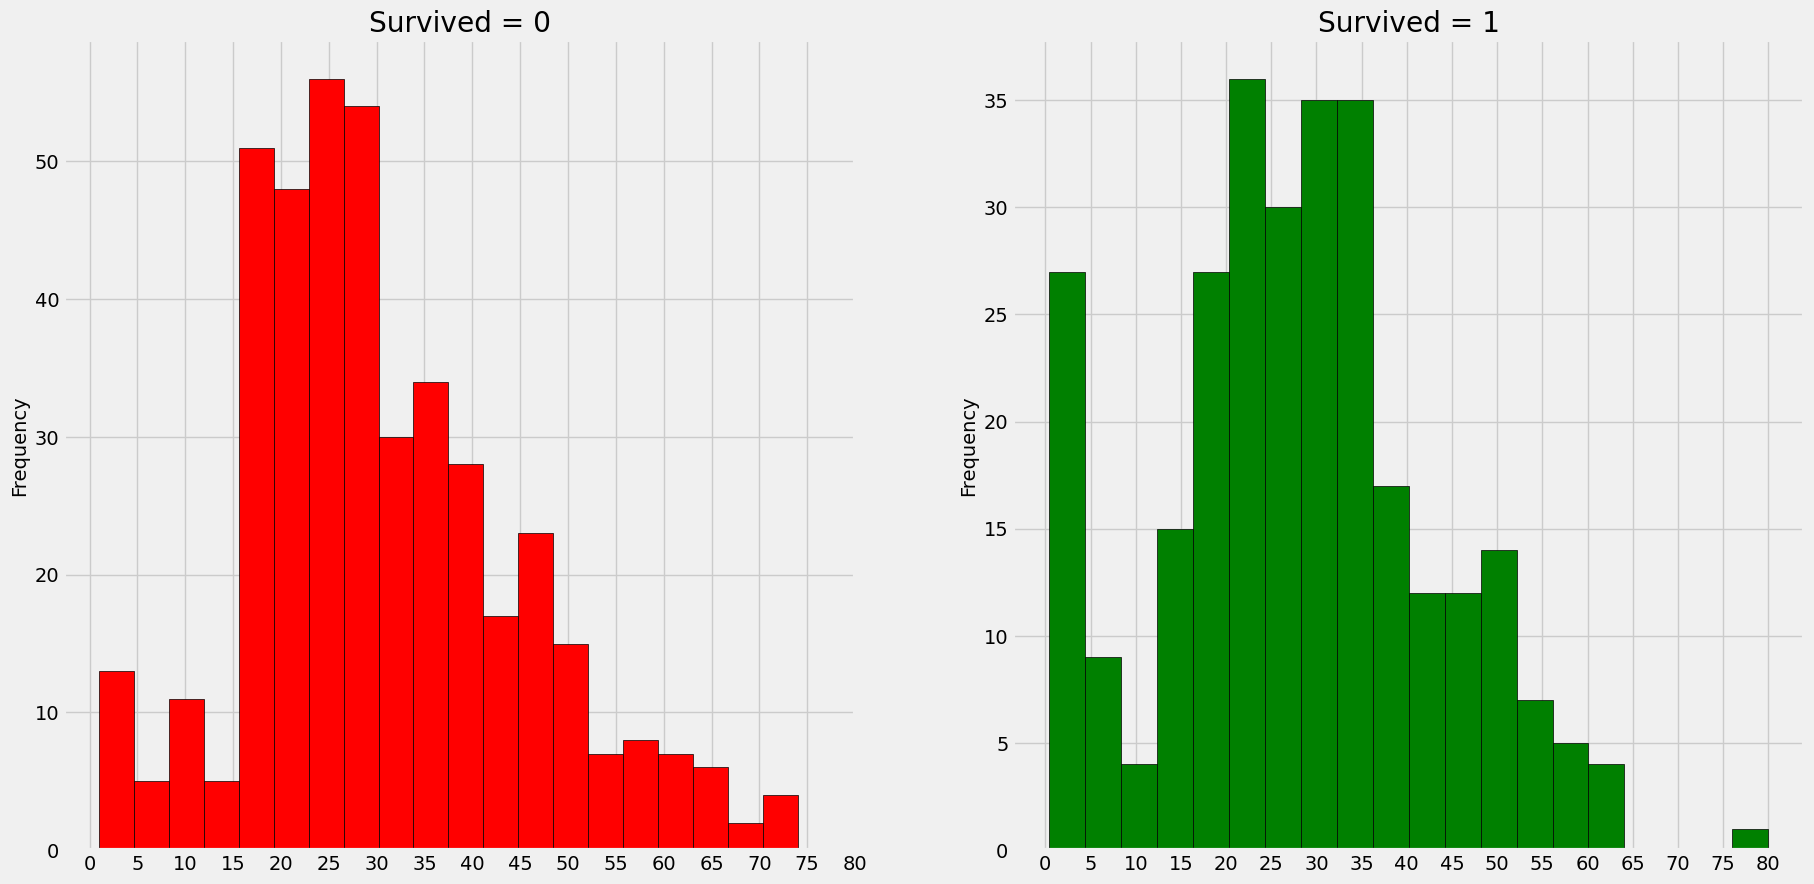

In [20]:
f, ax = plt.subplots(1,2, figsize=(20,10))
train[train['Survived']==0].Age.plot.hist(ax=ax[0],bins=20, edgecolor='black', color='red')
ax[0].set_title('Survived = 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)

train[train['Survived']==1].Age.plot.hist(ax=ax[1], color='green', bins=20, edgecolor='black')
ax[1].set_title('Survived = 1')
x2 = list(range(0,85,5))
ax[1].set_xticks(x2)

plt.show()

### Observations:
1) The Toddleres(age<5) were saved in large numbers( The women and Child First Policy).

2) The oldest Passenger was saved(80 years). 

3) Maximum number of deaths were in the age group of 30-40

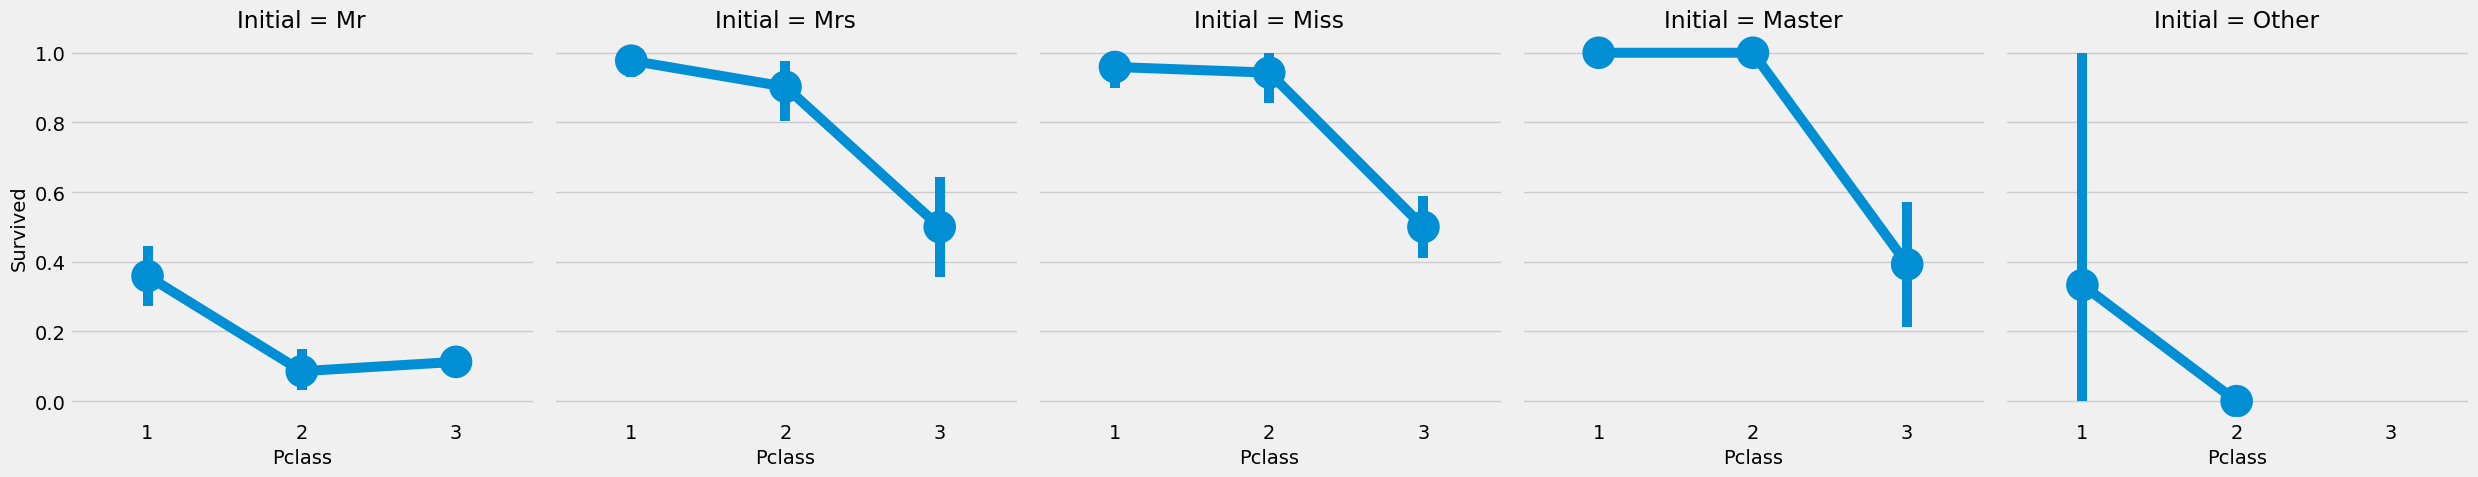

In [21]:
'''
x = x values
y = y values
col = 그래프를 나눌 기준. 주로 범주형 데이터가 들어있는 피쳐로 선택한다. 
kind = 그래프의 유형. “strip”, “swarm”, “box”, “violin”, “boxen”, “point”, “bar”, or “count”.
data = data
'''
sns.catplot(x='Pclass', y='Survived', col='Initial', kind='point' ,data=train)
plt.show()

The Women and Child first policy thus holds true irrespective of the class

### Embarked -> Categorical Value

In [22]:
pd.crosstab(
    [train.Embarked, train.Pclass], 
    [train.Sex, train.Survived], 
    margins=True
    ).style.background_gradient(cmap='summer_r')

__Chnances for Survival by Port Of Embarkation__

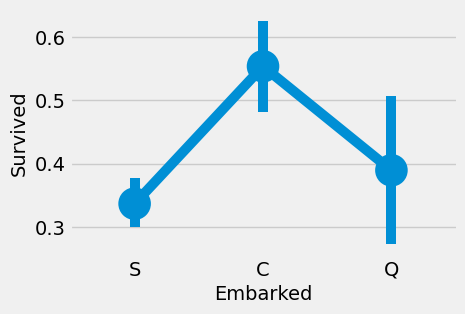

In [24]:
'''
figure을 많이 만들어 놓으면 어떤 figure이 있는지 알기 어려워 진다. 현재 figure를 확인하기 위한 방법으로는 plt.gcf()를 사용한다. 
gcf는 get current fugure의 약어로, 아래의 예에서 각각의 plt.gcf() 출력 결과가 어떻게 바뀌는지 알 수 있다.  
'''

sns.catplot(data=train, x='Embarked', y='Survived', kind='point')
fig = plt.gcf()
fig.set_size_inches(5,3) # inch기준으로 plot size를 생성
plt.show()

The chances for survival for Port C is highest around 0.55 while it is lowest for S.

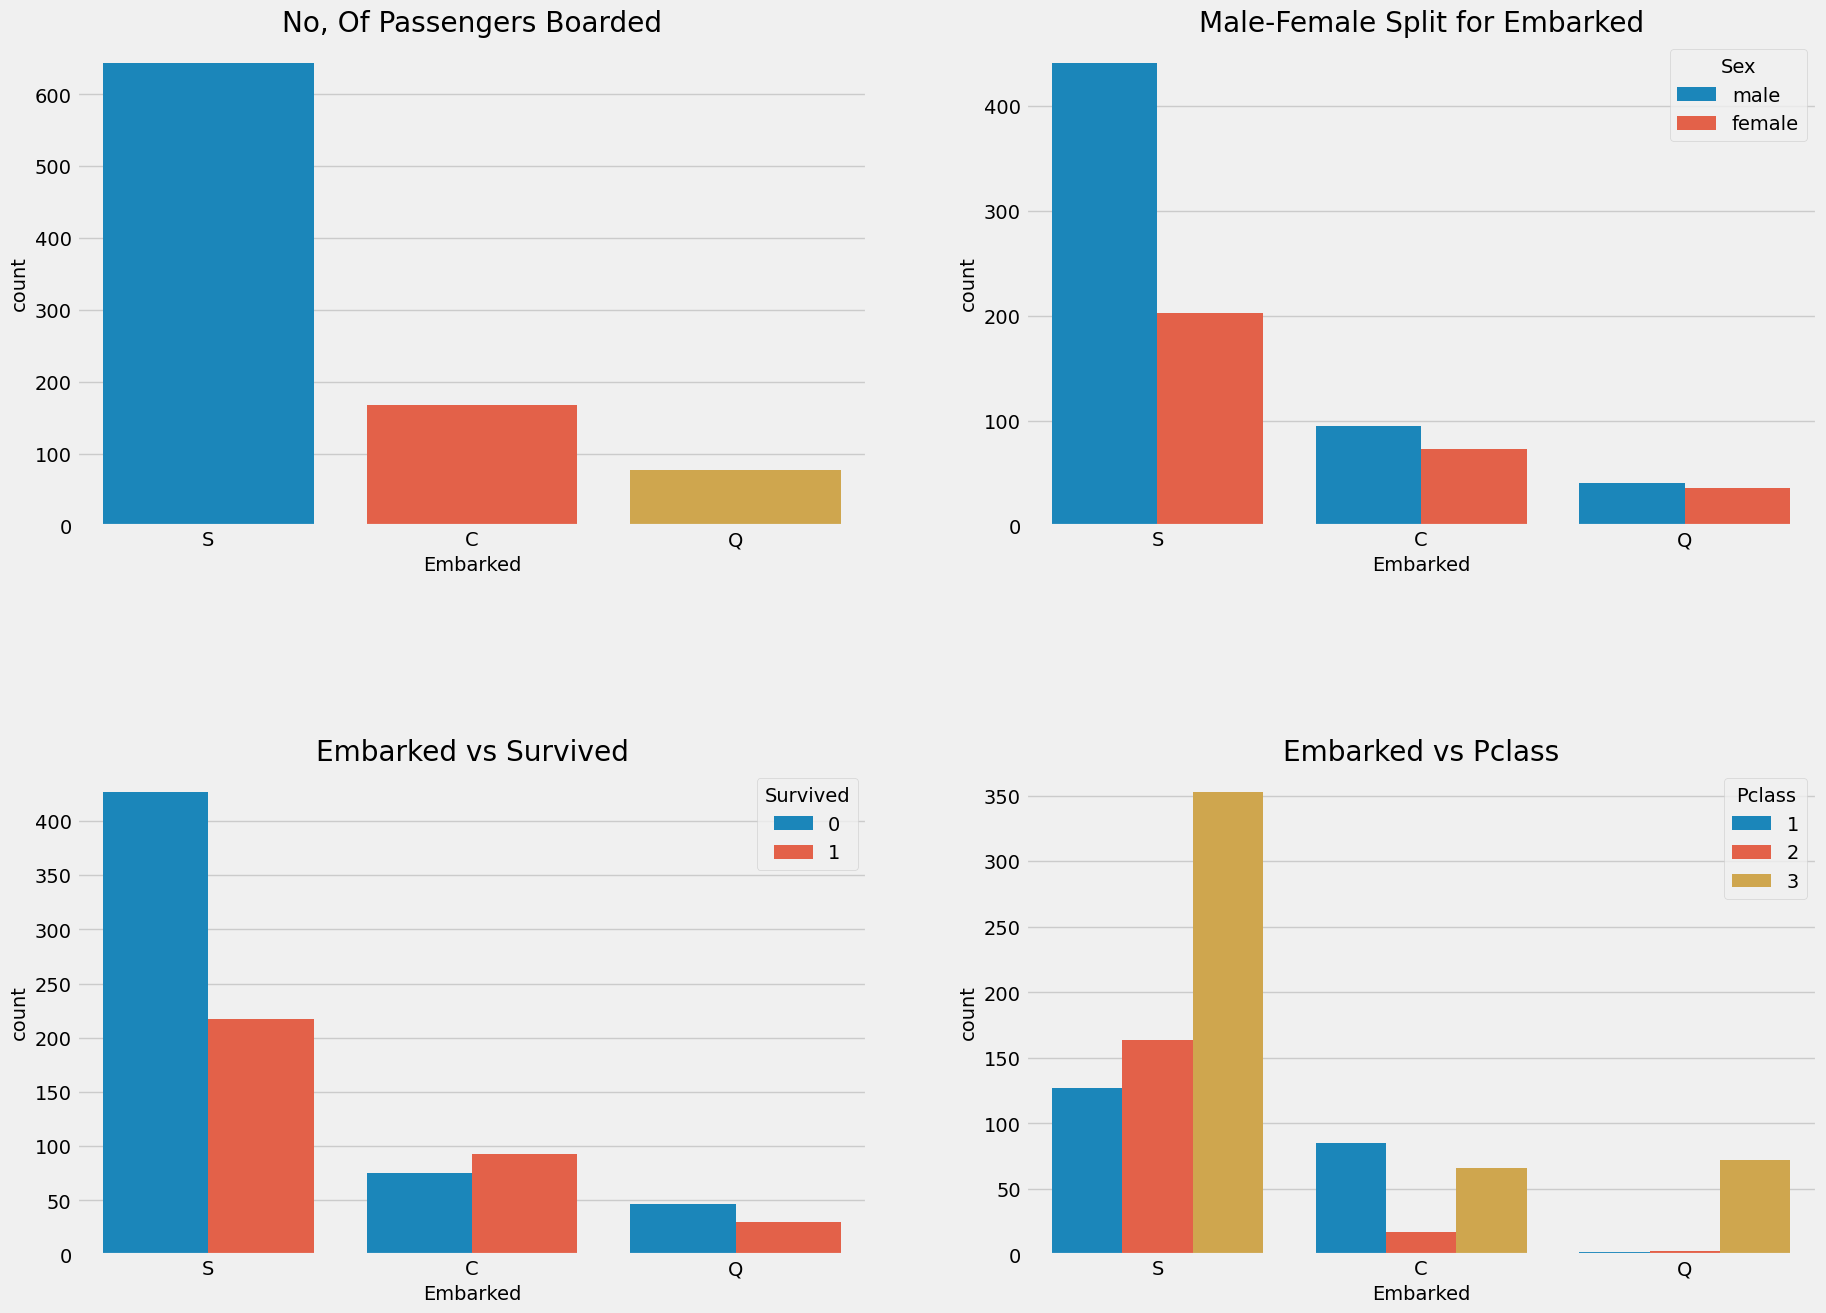

In [30]:
f, ax = plt.subplots(2,2,figsize=(20,15))
sns.countplot(data=train, x='Embarked', ax=ax[0,0])
ax[0,0].set_title('No, Of Passengers Boarded')

sns.countplot(data=train, x='Embarked', hue='Sex', ax=ax[0,1])
ax[0,1].set_title('Male-Female Split for Embarked')

sns.countplot(data=train, x='Embarked', hue='Survived', ax=ax[1,0])
ax[1,0].set_title('Embarked vs Survived')

sns.countplot(data=train, x='Embarked', hue='Pclass', ax=ax[1,1])
ax[1,1].set_title('Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)  # figure간의 간격을 설정할 수 있다. 
plt.show()

__Observations__
1) Maximum passengers boarded from S.Majority of them being from Pclass3.

2) The Passengers from C look to be lucky as a good proportion of them survived. The reason for this ,maybe the rescue of all the Pclass1 and Pclass2 Passengers.

3) The Embark S looks to the port from where majority of the rich people boarded. Still the chances for survival is low here, that is because many passengers from Pclass3 around __81%__ didn't survive.

4) Port Q had almost 95% of the passenfers were from Pclass3.




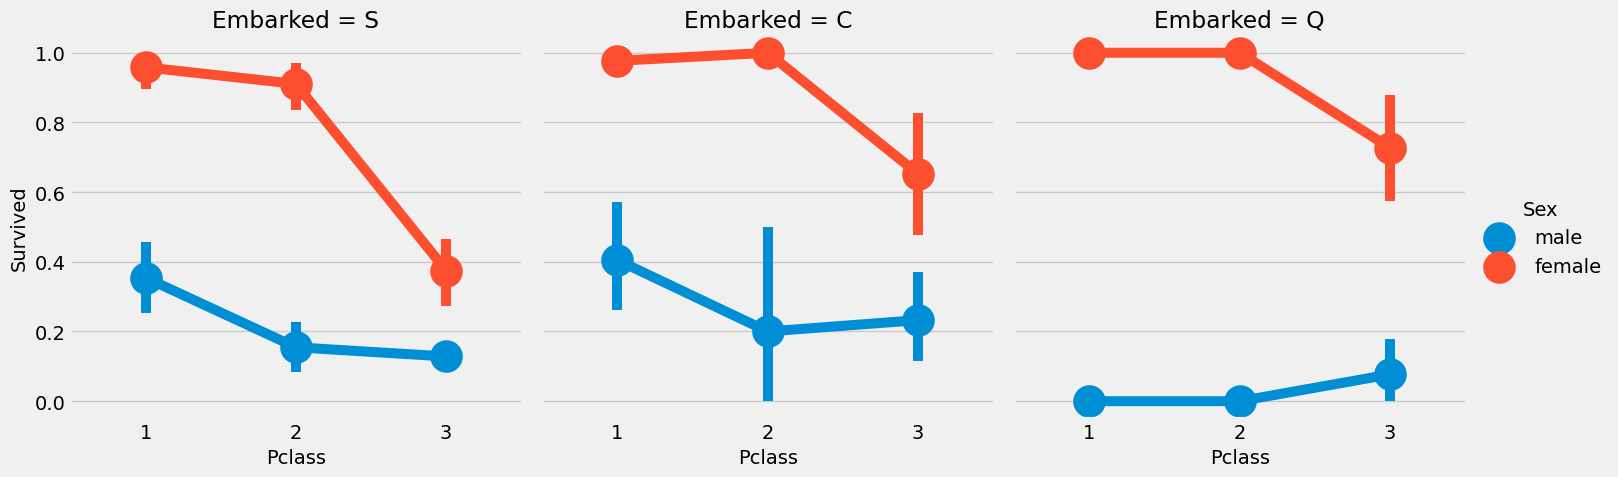

In [32]:
sns.catplot(data=train, x='Pclass', y='Survived', hue='Sex', col='Embarked', kind='point')
plt.show()

__Observations:__

1) The survival chances are almost 1 for women for Pclass1 and Pclass2 irrespective of the Pclass.

2) Port S looks to be very unluchy for Pclass3 Passengers as the survival rate for both men and women is very low.__(Money Matter)__

3) Port Q looks to be unluckiest for men, as almost all were from Pclass3.

__Fillinf Embarked NaN__

As we saw that maximum passengers boarded from Port S, we replace NaN with S.

In [33]:
train['Embarked'].fillna('S', inplace=True)

In [36]:
train.Embarked.isnull().any()

False

### SibSip -> Discrete Feature

This feature represents whether a person is alone or with his family members.

Sibling = brother, sister, stepbrother, stepsister

Spouse = husband, wife

In [42]:
pd.crosstab([train.SibSp],train.Survived).style.background_gradient(cmap='summer_r')


Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Initial'],
      dtype='object')